# Wstęp do uczenia maszynowego - projekt 2
## Kamień milowy 2
#### Michał Tomczyk, Mikołaj Piórczyński, grupa 3

Zbiór na którym będziemy działać przedstawia informacje dotyczące danych przeglądania użytkowników sklepu internetowego oferującego ubrania dla kobiet w ciąży. Dane zostały zebrane na przestrzeni pięciu miesięcy w 2008 roku i zawierają m.in. kategorię produktu, lokalizację zdjęcia na stronie, kraj pochodzenia adresu IP oraz cenę produktu w dolarach amerykańskich.

Dane: https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Motywacja 

W ramach motywacji dla przeprowadzanej przez nas klasteryzacji zdecydowaliśmy się grupować posiadane dane względem występujących w nich poszczególnych sesji w sklepie internetowym, czyli tak naprawdę klientów sklepu, mając nadzieję, że uda nam się wyróżnienić konkretne grupy klientów. Uzyskanie takich grup może być przydatną informacją dla właścicieli sklepów internetowych i twórców polityk sprzedażowych.


# Preprocessing

In [2]:
data = pd.read_csv("../data/e-shop clothing 2008.csv", sep=";")
data.head()

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


Agregujemy dane po zmiennej `session ID` aby móc klasteryzować użytkowników (sesje) zamiast pojedynczych kliknięć.

In [3]:
df = data.copy()
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df["weekday"] = df["date"].dt.dayofweek
df['price 2'] = df['price 2'].apply(lambda x: 0 if x==2 else 1)
df['model photography'] = df['model photography'].apply(lambda x: 0 if x==1 else 1)
df = pd.get_dummies(data=df, columns=['page 1 (main category)'])
df = df.groupby('session ID').aggregate(
    number_of_clicks = ('order', 'max'), # ilość odwiedzonych stron w czasie sesji 
    day = ('day', 'max'),
    weekday = ('weekday', 'max'),
    month = ('month', 'max'),
    price_min = ('price', 'min'),
    price_mean = ('price', 'mean'),
    price_max = ('price', 'max'),
    price_2_sum = ('price 2', 'sum'),
    cat1_sum = ('page 1 (main category)_1','sum'),
    cat2_sum = ('page 1 (main category)_2','sum'),
    cat3_sum = ('page 1 (main category)_3','sum'),
    cat4_sum = ('page 1 (main category)_4','sum'),
    country = ('country', 'max'),
    colour_mode = ('colour', pd.Series.mode),
    model_photography_sum = ('model photography', 'sum'),
    page_mode =  ('page', pd.Series.mode),
    page_max = ('page', 'max')
)


In [4]:
def select_random_value(x):
    if isinstance(x, np.ndarray):
        return np.random.choice(x, 1)[0]
    
    else:
        return x

In [5]:
def count_values(x):
    if isinstance(x, np.ndarray):
        return len(x)
    
    else:
        return 1

In [6]:
df["colour_mode_random"] = df["colour_mode"].apply(select_random_value)
df["colour_mode_count"] = df["colour_mode"].apply(count_values)
df.drop(columns=["colour_mode"], inplace=True)
df["page_mode"] = df["page_mode"].apply(count_values)
df["country"] = df["country"].apply(lambda x: 0 if x == 29 else 1)

In [7]:
df.shape

(24026, 18)

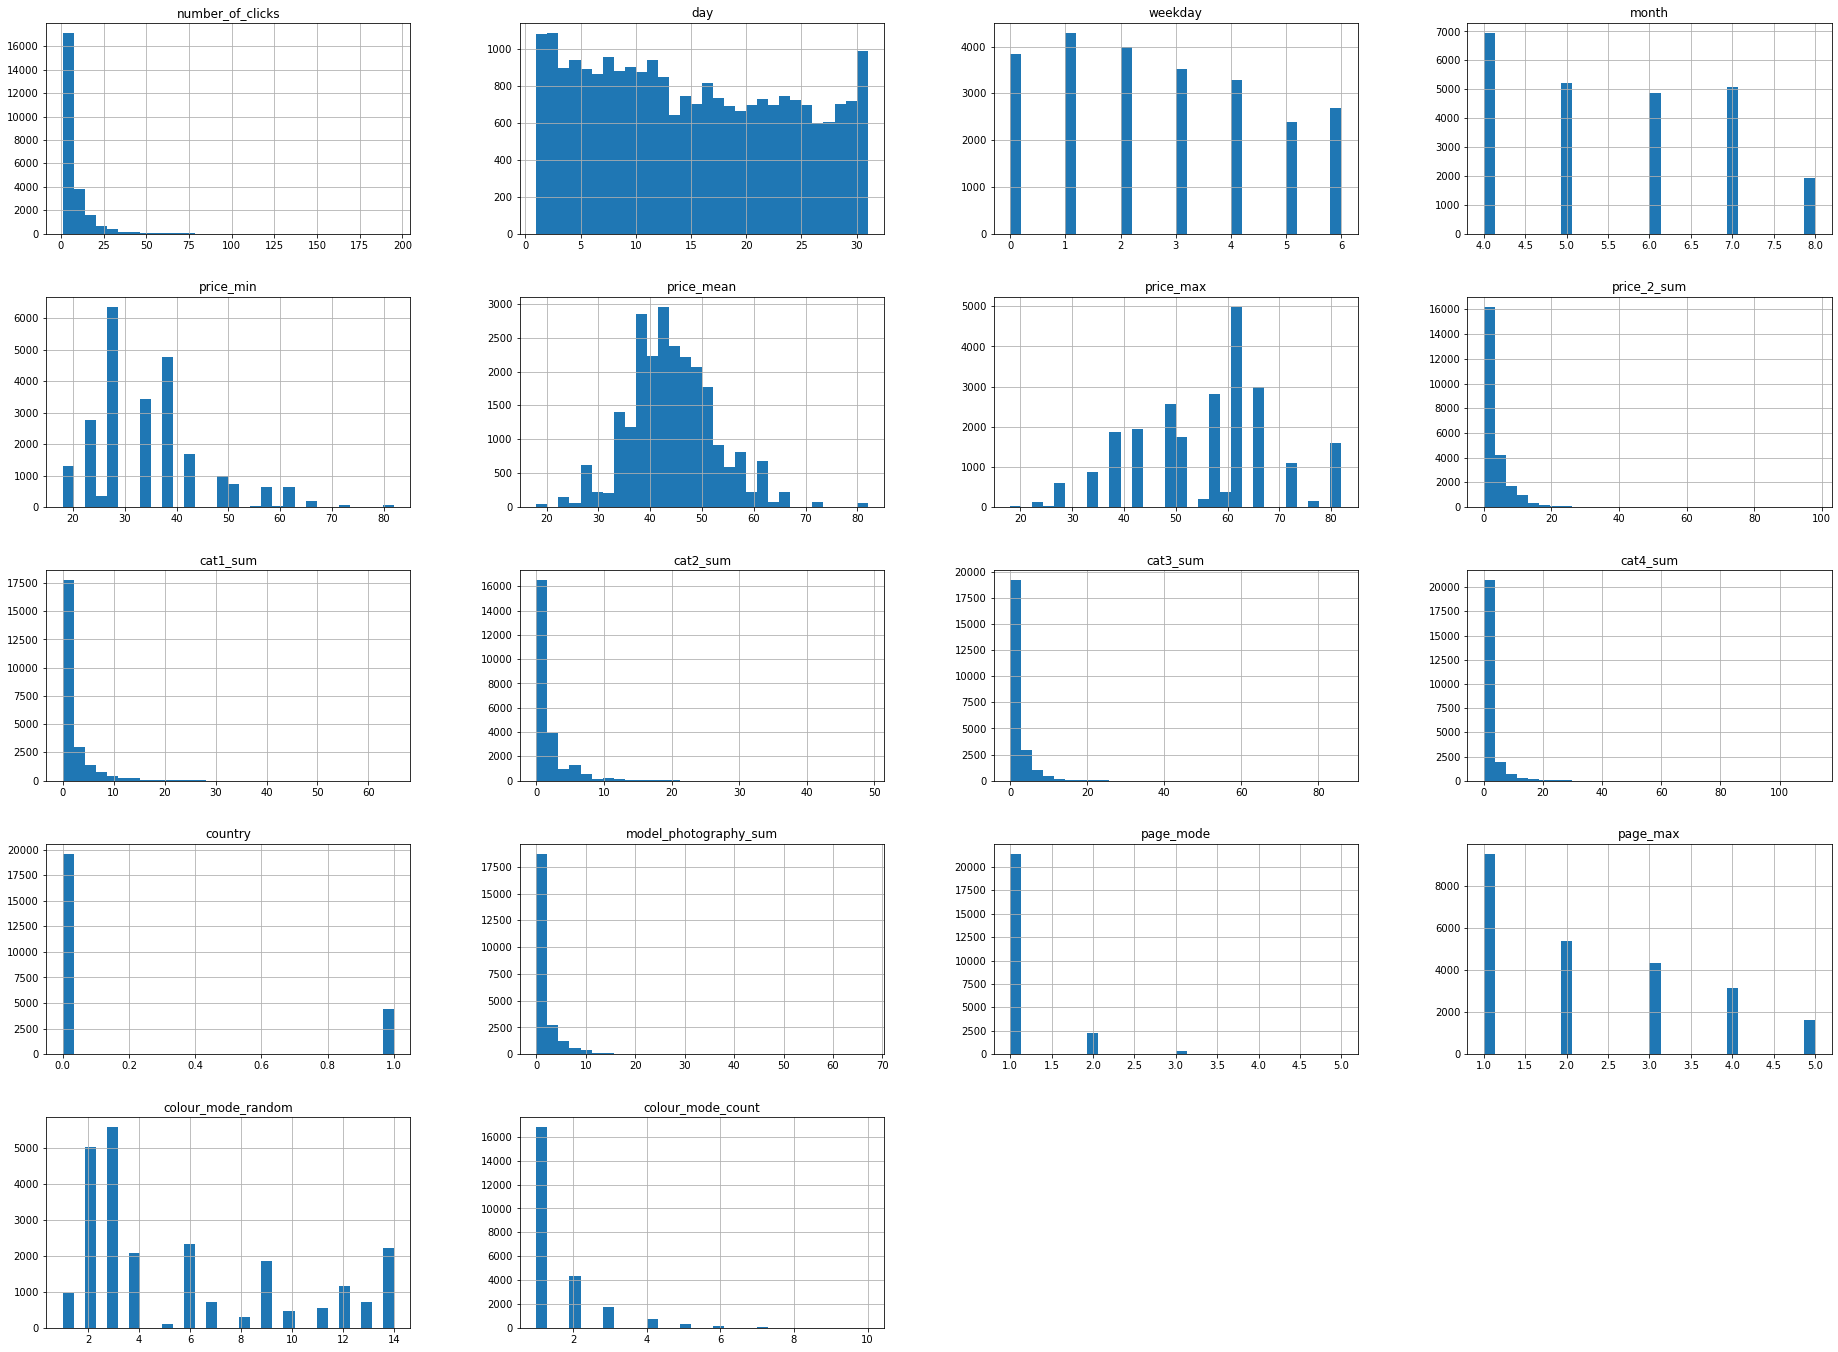

In [8]:
df.hist(bins=30, figsize=(32, 24))
plt.show()

Skalujemy zmienne, aby ich wartości znajdowały się w podobnych zakresach.

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

minmax_cols = ['number_of_clicks', 'day', 'weekday', 'month', 'price_2_sum', 'cat1_sum', 'cat2_sum',
       'cat3_sum', 'cat4_sum', 'country', 'model_photography_sum', 'page_mode',
       'page_max', 'colour_mode_random', 'colour_mode_count']

std_cols = ['price_min', 'price_mean', 'price_max']
cols = minmax_cols + std_cols

minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()

df_scaled = df.copy()
df_scaled[std_cols] = std_scaler.fit_transform(df[std_cols])
df_scaled[minmax_cols] = minmax_scaler.fit_transform(df[minmax_cols])

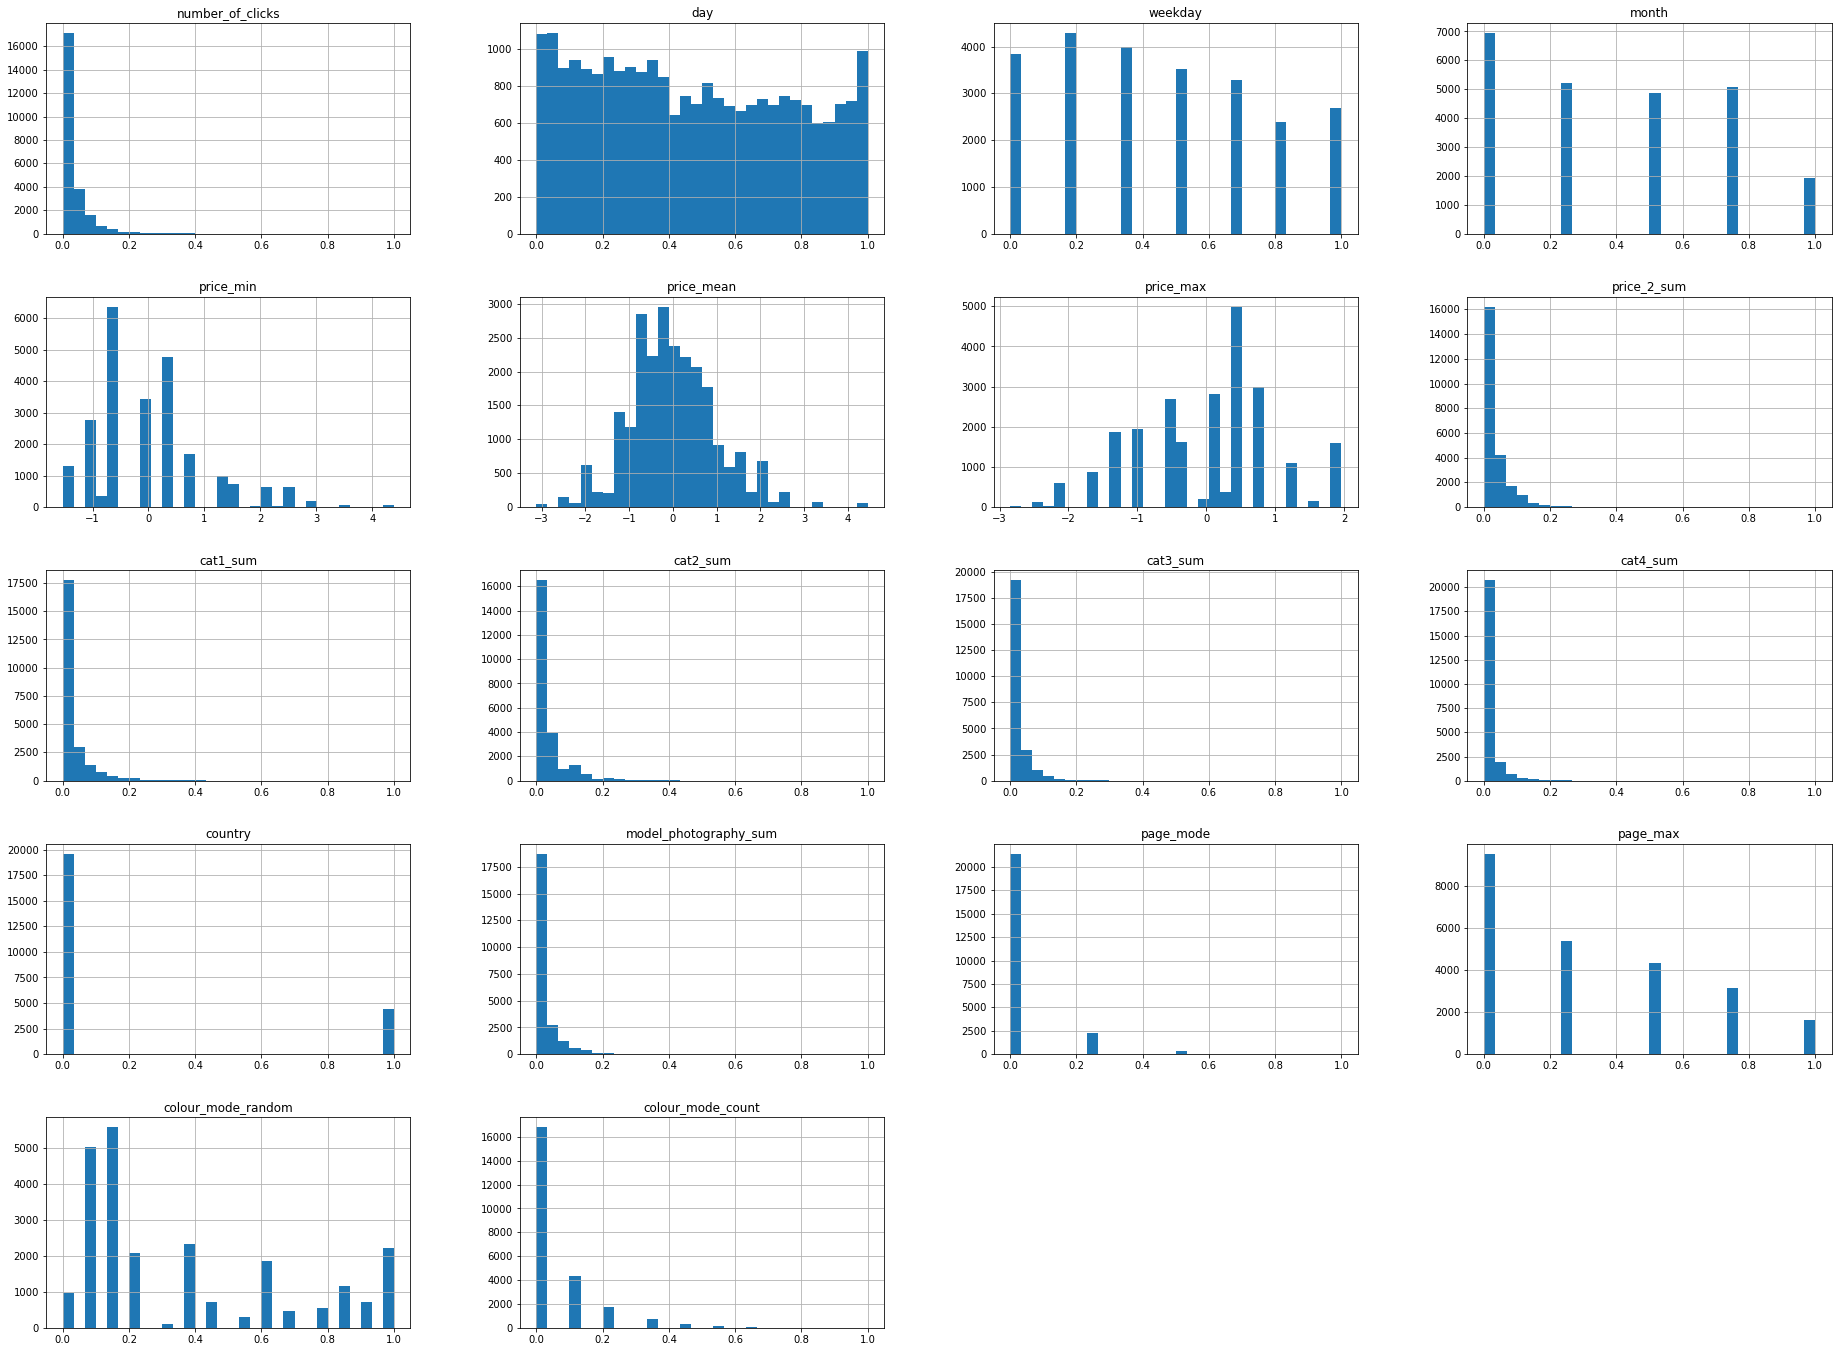

In [10]:
df_scaled.hist(bins=30, figsize=(32, 24))
plt.show()

### Podział zbioru

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_scaled, test_size = 0.3, random_state = 123)

In [12]:
X = df_train.values

# KMeans

In [13]:
from scipy.spatial import distance
from sklearn.cluster import KMeans

def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores
    

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

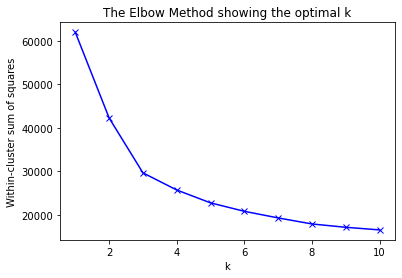

In [14]:
wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

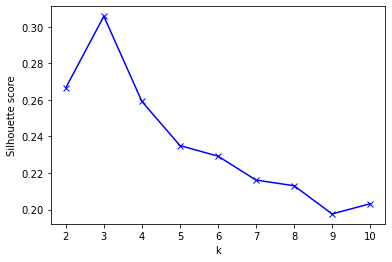

In [15]:
from sklearn.metrics import silhouette_score

cluster_num_seq = range(2, 11) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Zarówno na podstawie "metody łokcia" jak i porównując Silhouette score najlepszą liczbą klastrów wydają się być 3 klastry.

In [25]:
print(f'Minimal distance between clusters = {count_clustering_scores(X, 3, KMeans, min_interclust_dist):.2f}.')
print(f'Average distance between points in the same class = '
      f'{count_clustering_scores(X, 3, KMeans, mean_inclust_dist):.2f}.')
print(f'Standard deviation of distance between points in the same class = '
      f'{count_clustering_scores(X, 3, KMeans, std_dev_of_inclust_dist):.3f}.')
print(f'Average distance to cluster center = '
      f'{count_clustering_scores(X, 3, KMeans, mean_dist_to_center):.2f}.')
print(f'Silhouette Score = {count_clustering_scores(X, cluster_num=3, model=KMeans, score_fun=silhouette_score):.3f}.')

Minimal distance between clusters = 0.18.
Average distance between points in the same class = 1.82.
Standard deviation of distance between points in the same class = 0.096.
Average distance to cluster center = 1.29.
Silhouette Score = 0.306.


## Wizualizacja uzyskanych klastrów

### PCA

In [20]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)

    pca = PCA(n_components=2)
    pca.fit(X)
    X2D = pca.transform(X)
    plt.scatter(X2D[:, 0], X2D[:, 1], c=y_kmeans, s=30, cmap='viridis')

    centers = kmeans.cluster_centers_
    centers2D = pca.transform(centers)
    plt.scatter(centers2D[:, 0], centers2D[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-means clusters')
    plt.show()

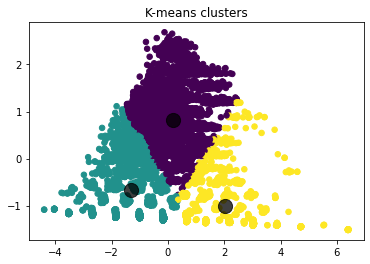

In [33]:
plot_kmeans_clusters(X, n_clusters=3)

### tSNE

In [21]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

def plot_kmeans_clusters_tSNE(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)

    tSNE = TSNE(learning_rate=400, random_state=42)
    tsne_features = tSNE.fit_transform(X)

    xs = tsne_features[:, 0]
    ys = tsne_features[:, 1]
    plt.figure(figsize=(12,8))
    plt.scatter(x=xs,y=ys, c=y_kmeans, s=30, cmap='viridis', alpha=0.75)
    plt.show()

C:\Users\micha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


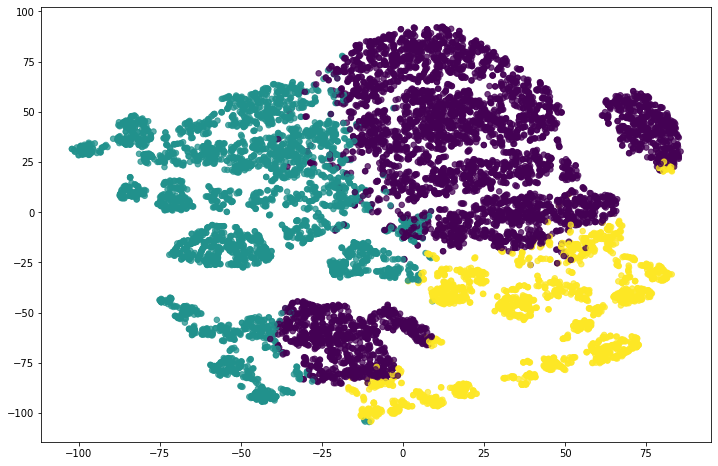

In [35]:
plot_kmeans_clusters_tSNE(X, n_clusters=3)

## Interpretacja uzyskanych klastrów

In [36]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_scaled.columns)
centers

,number_of_clicks,day,weekday,month,price_min,price_mean,price_max,price_2_sum,cat1_sum,cat2_sum,cat3_sum,cat4_sum,country,model_photography_sum,page_mode,page_max,colour_mode_random,colour_mode_count
0,0.052445,0.453306,0.442279,0.401906,-0.444197,0.140285,0.675206,0.060364,0.054560,0.055198,0.028751,0.020477,0.187823,0.042011,0.032597,0.416997,0.328654,0.060097
1,0.012833,0.448403,0.450752,0.376837,-0.242368,-0.939453,-1.128943,0.013779,0.011314,0.005601,0.011537,0.012938,0.167258,0.016805,0.036683,0.257603,0.395688,0.055302
2,0.005267,0.444691,0.450526,0.407051,1.732094,1.398762,0.236094,0.018790,0.007799,0.021646,0.004564,0.000409,0.198718,0.004975,0.023176,0.134985,0.428311,0.034188


In [37]:
centers[std_cols] = std_scaler.inverse_transform(centers[std_cols])
centers[minmax_cols] = minmax_scaler.inverse_transform(centers[minmax_cols])
centers

,number_of_clicks,day,weekday,month,price_min,price_mean,price_max,price_2_sum,cat1_sum,cat2_sum,cat3_sum,cat4_sum,country,model_photography_sum,page_mode,page_max,colour_mode_random,colour_mode_count
0,11.017075,14.599172,2.653674,5.607623,29.767506,45.586139,64.981200,5.674198,3.546395,2.704726,2.472577,2.293377,0.187823,2.814764,1.130390,2.667989,5.272508,1.540876
1,3.451090,14.452103,2.704511,5.507349,31.946275,36.487614,40.998226,1.295236,0.735428,0.274455,0.992144,1.449062,0.167258,1.125950,1.146731,2.030411,6.143943,1.497719
2,2.005917,14.340730,2.703156,5.628205,53.260848,56.190836,59.143984,1.766272,0.506903,1.060651,0.392505,0.045858,0.198718,0.333333,1.092702,1.539941,6.568047,1.307692


1. 11 produktów, 30-65\\$, średnia 45\\$, 6 produktów w cenie wyzszej niż śrenia w kategorii, 3.5 spodni, 3 spódnice, 2.5 bluzki, 2 produkty z przeceny, najdalsze strony, burgundowy - klient dużo przeglądający, więc zarówno ogląda rzeczy tanie jak i drogie. Wydaje się, że jest to średnio zamożny klient
2. 3.5 produktu, środa/czwartek, 32-41\\$, średnia 36\\$, przeceny ok. 1.5, 1 bluzka, 1 głównie 1 strona, 2 strona max, szary ulubiony, jeszcze jakiś ulubiony może mieć - klient bardziej budżetowy, obserwujący rzeczy na promocji, ale mało przeglądający
3. 2 produkty, 53-59\\$, średnia 56\\$, 1 spódnica, 0.5 spodni, 20% nie Polska, głównie 1 strona, szary - klient bardziej zamożny, mało przeglądający

# DBSCAN

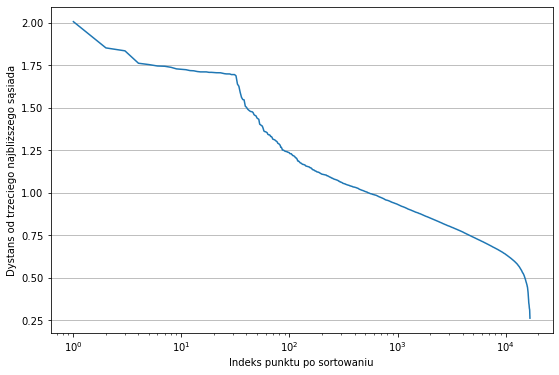

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#wybór parametrów
minPts = X.shape[1] * 2
nbrs = NearestNeighbors(n_neighbors=minPts).fit(X)
distances, indices = nbrs.kneighbors(X)
distanceDec = sorted(distances[:, minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,X.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

In [22]:
def plot_dbs_clusters(X, min_samples, eps):
    dbs = DBSCAN(eps = eps, min_samples = min_samples)
    y_dbs = dbs.fit_predict(X)
    pca = PCA(n_components=2)
    pca.fit(X)
    X2D = pca.transform(X)
    plt.scatter(X2D[:, 0], X2D[:, 1], c=y_dbs, s=30, cmap='viridis')
    plt.title('DBSCAN clusters')
    plt.show()

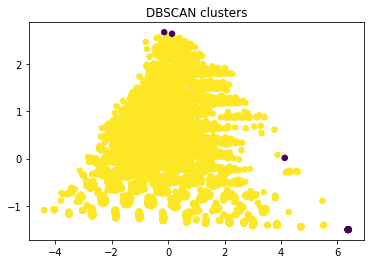

In [24]:
plot_dbs_clusters(X, min_samples=36, eps=1.25)

# GMM

In [27]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import homogeneity_score

def count_clustering_scores_gmm(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_components=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

In [28]:
print(f'Minimal distance between clusters = {count_clustering_scores_gmm(X, 3, GaussianMixture, min_interclust_dist):.2f}.')
print(f'Average distance between points in the same class = '
      f'{count_clustering_scores_gmm(X, 3, GaussianMixture, mean_inclust_dist):.2f}.')
print(f'Standard deviation of distance between points in the same class = '
      f'{count_clustering_scores_gmm(X, 3, GaussianMixture, std_dev_of_inclust_dist):.3f}.')
print(f'Average distance to cluster center = '
      f'{count_clustering_scores_gmm(X, 3, GaussianMixture, mean_dist_to_center):.2f}.')
print(f'Silhouette Score = {count_clustering_scores_gmm(X, cluster_num=3, model=GaussianMixture, score_fun=silhouette_score):.3f}.')

Minimal distance between clusters = 0.01.
Average distance between points in the same class = 2.18.
Standard deviation of distance between points in the same class = 0.341.
Average distance to cluster center = 1.55.
Silhouette Score = 0.006.


In [29]:
def plot_gmm_clusters(X, n_components):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X)
    y_gmm = gmm.predict(X)

    pca = PCA(n_components=2)
    pca.fit(X)
    X2D = pca.transform(X)
    plt.scatter(X2D[:, 0], X2D[:, 1], c=y_gmm, s=30, cmap='viridis')

   # means = gmm.means_
   # means2D = pca.transform(means)
    #plt.scatter(means2D[:, 0], means2D[:, 1], c='black', s=200, alpha=0.75)
    plt.title('GaussianMixture clusters')
    plt.show()

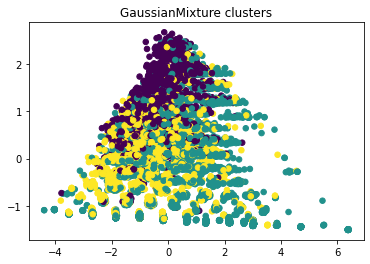

In [32]:
plot_gmm_clusters(X, n_components=3)

# Hierarchical clustering 

In [33]:
from sklearn.cluster import AgglomerativeClustering

print(f'Minimal distance between clusters = {count_clustering_scores(X, 3, AgglomerativeClustering, min_interclust_dist):.2f}.')
print(f'Average distance between points in the same class = '
      f'{count_clustering_scores(X, 3, AgglomerativeClustering, mean_inclust_dist):.2f}.')
print(f'Standard deviation of distance between points in the same class = '
      f'{count_clustering_scores(X, 3, AgglomerativeClustering, std_dev_of_inclust_dist):.3f}.')
print(f'Average distance to cluster center = '
      f'{count_clustering_scores(X, 3, AgglomerativeClustering, mean_dist_to_center):.2f}.')

Minimal distance between clusters = 0.26.
Average distance between points in the same class = 1.83.
Standard deviation of distance between points in the same class = 0.134.
Average distance to cluster center = 1.31.
Silhouette Score = 0.265.


In [35]:
print(f'Silhouette Score = {count_clustering_scores(X, cluster_num=3, model=AgglomerativeClustering, score_fun=silhouette_score):.3f}.')

Silhouette Score = 0.265.


In [41]:
def plot_hierarchical_clusters(X, n_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    y = model.fit_predict(X)

    pca = PCA(n_components=2)
    pca.fit(X)
    X2D = pca.transform(X)
    plt.scatter(X2D[:, 0], X2D[:, 1], c=y, s=30, cmap='viridis')

    plt.title('Agglomerative clusters')
    plt.show()

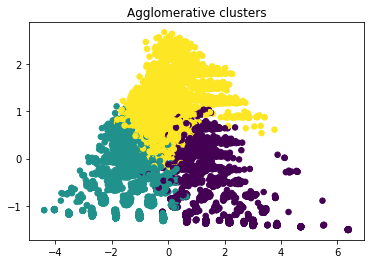

In [42]:
plot_hierarchical_clusters(X, n_clusters=3)

# Walidacja na zbiorze testowym

In [44]:
X_test = df_test.values

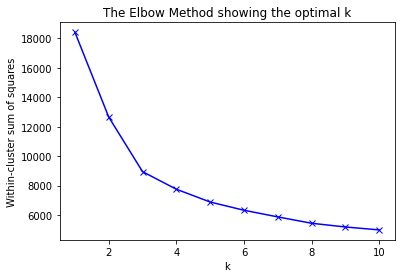

In [45]:
wcss_vec = count_wcss_scores(X_test, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

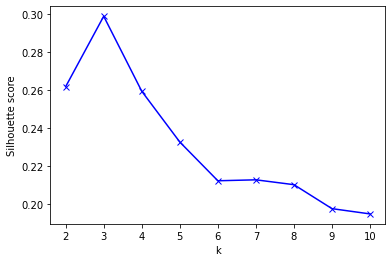

In [46]:
cluster_num_seq = range(2, 11) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(X_test, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

In [47]:
print(f'Minimal distance between clusters = {count_clustering_scores(X_test, 3, KMeans, min_interclust_dist):.2f}.')
print(f'Average distance between points in the same class = '
      f'{count_clustering_scores(X_test, 3, KMeans, mean_inclust_dist):.2f}.')
print(f'Standard deviation of distance between points in the same class = '
      f'{count_clustering_scores(X_test, 3, KMeans, std_dev_of_inclust_dist):.3f}.')
print(f'Average distance to cluster center = '
      f'{count_clustering_scores(X_test, 3, KMeans, mean_dist_to_center):.2f}.')

Minimal distance between clusters = 0.30.
Average distance between points in the same class = 1.82.
Standard deviation of distance between points in the same class = 0.124.
Average distance to cluster center = 1.30.


Także optymalna liczba klastrów równa 3, odległość między dwoma najbliższymi klastrami wzrosła.

In [48]:
count_clustering_scores(X_test, cluster_num=3, model=KMeans, score_fun=silhouette_score)

0.2989459527024916

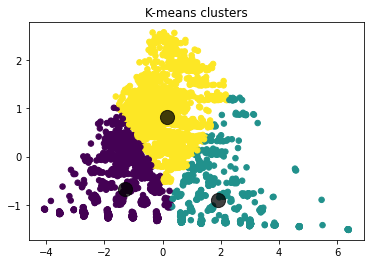

In [49]:
plot_kmeans_clusters(X_test, n_clusters=3)

C:\Users\micha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


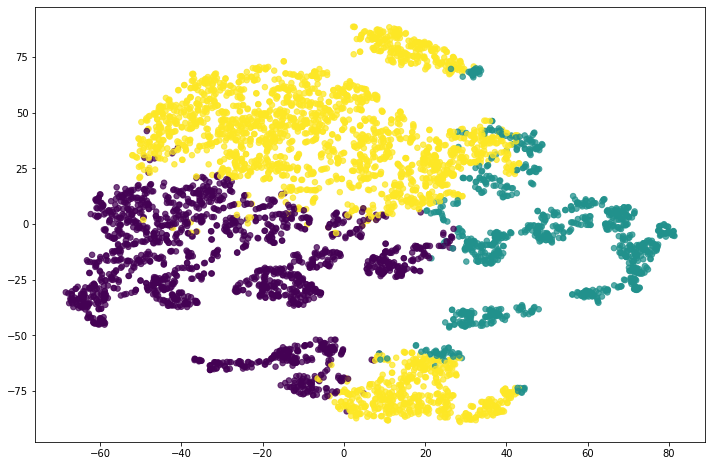

In [52]:
plot_kmeans_clusters_tSNE(X_test, n_clusters=3)

In [54]:
kmeans1 = KMeans(n_clusters=3, random_state=123)
kmeans1.fit(X_test)
centers = pd.DataFrame(kmeans1.cluster_centers_, columns=df_test.columns)
centers

,number_of_clicks,day,weekday,month,price_min,price_mean,price_max,price_2_sum,cat1_sum,cat2_sum,cat3_sum,cat4_sum,country,model_photography_sum,page_mode,page_max,colour_mode_random,colour_mode_count
0,0.013431,0.446694,0.424810,0.392481,-0.223515,-0.895936,-1.081755,0.014423,0.011820,0.006556,0.011642,0.013166,0.157402,0.017056,0.037303,0.250878,0.414412,0.059034
1,0.006350,0.451809,0.428723,0.384043,1.599627,1.366859,0.273920,0.020315,0.009116,0.023817,0.004602,0.000513,0.241489,0.005224,0.023670,0.137500,0.423813,0.039125
2,0.053926,0.455458,0.445626,0.390592,-0.459954,0.126544,0.689362,0.062028,0.055095,0.055827,0.030042,0.021426,0.204839,0.043207,0.031185,0.431477,0.315394,0.063505


In [55]:
centers[std_cols] = std_scaler.inverse_transform(centers[std_cols])
centers[minmax_cols] = minmax_scaler.inverse_transform(centers[minmax_cols])
centers

,number_of_clicks,day,weekday,month,price_min,price_mean,price_max,price_2_sum,cat1_sum,cat2_sum,cat3_sum,cat4_sum,country,model_photography_sum,page_mode,page_max,colour_mode_random,colour_mode_count
0,3.565243,14.400819,2.548859,5.569924,32.149795,36.854310,41.625512,1.355764,0.768286,0.321240,1.001170,1.474547,0.157402,1.142774,1.149210,2.003511,6.387361,1.531305
1,2.212766,14.554255,2.572340,5.536170,51.830851,55.922004,59.646809,1.909574,0.592553,1.167021,0.395745,0.057447,0.241489,0.350000,1.094681,1.550000,6.509574,1.352128
2,11.299958,14.663746,2.673759,5.562370,29.597413,45.470352,65.169378,5.830622,3.581143,2.735503,2.583646,2.399666,0.204839,2.894869,1.124739,2.725907,5.100125,1.571548


Wnioski pokrywają się z wnioskami dla reszty zbioru.

# Wnioski 

Otrzymane wyniki wydają się być "najlepsze" dla metody k-średnich, jednak uzyskane w ten sposób klastry nie są zadawolającej jakości. Jako dalsze możliwości ulepszenia uzyskanych wyników widzimy dodanie informacji o konkretnych produktach np. poprzez one-hot-encoding. Takie podejście zwiększy rozmiar danych i będzie wymagało redukcji wymiarowości, jednak zapewni więcej informacji i może doprowadzić do lepszej klasteryzacji. Może być również tak, że w analizowanym zbiorze istnieje tylko jeden segment klientów - wszyscy charakteryzują się tak naprawdę podobnymi cechami i jakakolwiek segmentacja nie ma sensu. 